# 0. Install and Import Dependencies

In [4]:
!pip install easyocr
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=0633c938d6aefb08381bd2af129ef24c6bae355bf161cb60f9e721306e3244af
  Stored in directory: /Users/vishnumano/Library/Caches/pip/wheels/31/d0/2c/87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils


In [6]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

# 1. Read in Image, Grayscale, and Blur

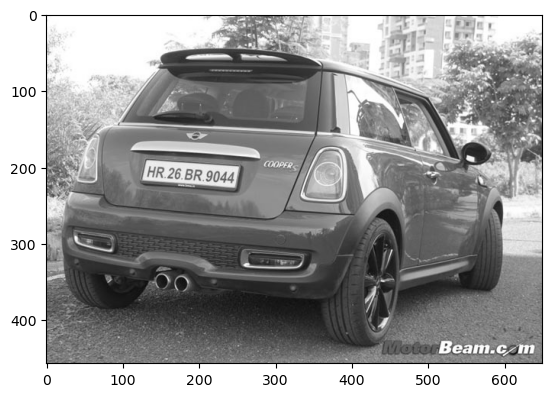

In [74]:
img = cv2.imread('image1.jpg') # read in image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # recolor image2 from BlueGreenRed to Gray
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)) # convert grayscaled image2 from BGR to RGB

# 2. Apply Filter and Find Edges for Localization

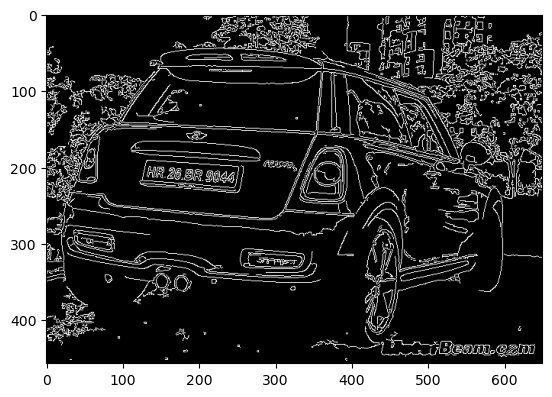

In [75]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # Noise Reduction through Bilateral Filter
edged = cv2.Canny(bfilter, 30, 200) # Edge detection using Canny algorithm
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB)) # convert edged from BGR to RGB for visualization

# 3. Find Contours and Apply Mask

In [76]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Finding Contours - params(input image, return type(tree to find different levels of contours), type of result (approximated/simplified version of countour))
contours = imutils.grab_contours(keypoints) # Grabs the contours and simplifies them to tuple
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # sorts top 10 contours by descending contour area

In [77]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True) # approximates the polygon from contour - params(countour, specifies how fine grained the contour is (10 is fine enough to say its a rectangle but not fine enough to say it has more than 4 points))
    if len(approx) == 4: # if approximation has 4 key points
        location = approx # stores coordinates of predicted rectangle
        break

In [78]:
location

array([[[122, 219]],

       [[246, 227]],

       [[252, 200]],

       [[132, 191]]], dtype=int32)

In [79]:
mask = np.zeros(gray.shape, np.uint8) # applies blank mask that is the same shape as original grayscaled image params(the shape of the original image, the datatype of the zeros)
new_image = cv2.drawContours(mask, [location], 0, 255, -1) # draws the contours params(the mask, what contour should be drawn, )
new_image = cv2.bitwise_and(img, img, mask=mask) # overlays mask over original image

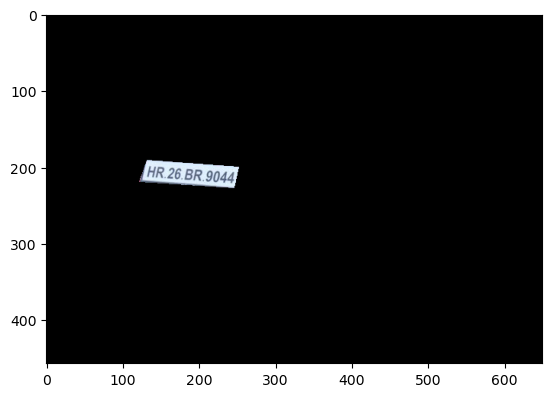

In [80]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [81]:
(x,y) = np.where(mask==255) # identifies every section where image is not black
(x1, y1) = (np.min(x), np.min(y)) # grabs coordinates of top left corner 
(x2, y2) = (np.max(x), np.max(y)) # grabs coordinates of bottom right corner
cropped_image = gray[x1:x2+1, y1:y2+1] # crops the image using both corner coordinates (the +1 adds marginal buffer)

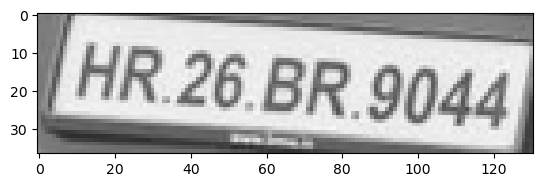

In [82]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# 4. Use Easy OCR to Read Text

In [83]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[6, 4], [128, 4], [128, 34], [6, 34]], 'HR.26 BR.9044', 0.6050775185866815)]

# 5. Render Result

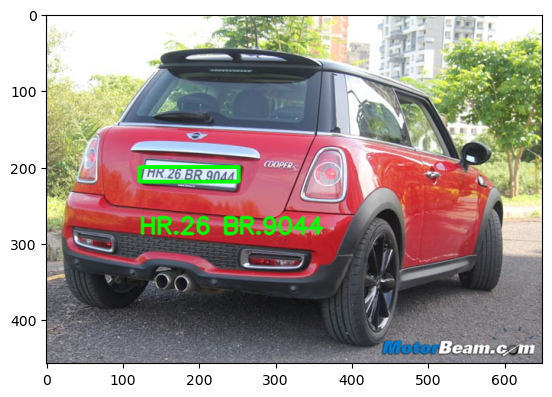

In [91]:
text = result[0][-2] # grabbed text
font = cv2.FONT_HERSHEY_SIMPLEX # font
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA) # specified details of text
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3) # draw rectangle
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))